# 0.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier


warnings.filterwarnings('ignore')

In [370]:
# Load Data
op = 0 # 0: Local, 1: Kaggle

if not op: # Local
    train_path = './data/train.csv'
    test_path = './data/test.csv'
    sub_path = './data/gender_submission.csv'
    save_path = './data/submission.csv'
else:  # Kaggle
    train_path = '/kaggle/input/titanic/train.csv'
    test_path = '/kaggle/input/titanic/test.csv'
    sub_path = '/kaggle/input/titanic/gender_submission.csv'    
    save_path = '/kaggle/working/submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sub = pd.read_csv(sub_path)

print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


# 1.

In [371]:
# Remove unnecessary columns
df_train = df_train.drop(columns=['Name', 'Ticket'])
df_test = df_test.drop(columns=['Name', 'Ticket'])

# Check NaN
print(df_train[df_test.columns].isnull().sum())
print("=====================")
print(df_test[df_test.columns].isnull().sum())

PassengerId      0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Sex              0
Age             86
SibSp            0
Parch            0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [372]:
# NaN list:  Age, Cabin, Fare, Embarked

# Age
def age_to_group(age):
    if pd.isna(age):
        return 7
    elif age <= 10:
        return 0
    elif age <= 20:
        return 1
    elif age <= 30:
        return 2
    elif age <= 40:
        return 3
    elif age <= 50:
        return 4
    elif age <= 60:
        return 5
    else:
        return 6

df_train['AgeGroup'] = df_train['Age'].apply(age_to_group)
df_test['AgeGroup'] = df_test['Age'].apply(age_to_group)

# Fare
df_test['Fare'] = df_test['Fare'].fillna(df_test.groupby('Pclass')['Fare'].transform('mean'))

# Embarked
# df_train['Embarked'] = df_train['Embarked'].fillna('N')

df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,AgeGroup
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,2
1,2,1,1,female,38.0,1,0,71.2833,C85,C,3
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,2
3,4,1,1,female,35.0,1,0,53.1000,C123,S,3
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,3


# 2. Feature Engineering

In [373]:
# Encoding
df_train = pd.get_dummies(df_train, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)
df_train.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,AgeGroup,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,1,0,22.0,1,0,7.2500,NaN,2,False,True,True,False,True
1,2,1,38.0,1,0,71.2833,C85,3,False,False,False,False,False
2,3,1,26.0,0,0,7.9250,NaN,2,False,True,False,False,True
3,4,1,35.0,1,0,53.1000,C123,3,False,False,False,False,True
4,5,0,35.0,0,0,8.0500,NaN,3,False,True,True,False,True


In [374]:
# Add Feature
df_train['FamilySize'] = (df_train['SibSp'] + df_train['Parch'])
df_test['FamilySize'] = (df_test['SibSp'] + df_test['Parch'])
print(df_train.columns)
df_train.head(10)

Index(['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'AgeGroup', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q',
       'Embarked_S', 'FamilySize'],
      dtype='object')


,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,AgeGroup,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,FamilySize
0,1,0,22.0,1,0,7.2500,NaN,2,False,True,True,False,True,1
1,2,1,38.0,1,0,71.2833,C85,3,False,False,False,False,False,1
2,3,1,26.0,0,0,7.9250,NaN,2,False,True,False,False,True,0
3,4,1,35.0,1,0,53.1000,C123,3,False,False,False,False,True,1
4,5,0,35.0,0,0,8.0500,NaN,3,False,True,True,False,True,0
5,6,0,NaN,0,0,8.4583,NaN,7,False,True,True,True,False,0
6,7,0,54.0,0,0,51.8625,E46,5,False,False,True,False,True,0
7,8,0,2.0,3,1,21.0750,NaN,0,False,True,True,False,True,4
8,9,1,27.0,0,2,11.1333,NaN,2,False,True,False,False,True,2
9,10,1,14.0,1,0,30.0708,NaN,1,True,False,False,False,False,1


In [375]:
# Select Feature
drop_cols = ['PassengerId', 'Age', 'SibSp', 'Parch', 'Cabin']
df_train.drop(columns=drop_cols, inplace=True)
df_test.drop(columns=drop_cols, inplace=True)
df_train.head()

,Survived,Fare,AgeGroup,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,FamilySize
0,0,7.2500,2,False,True,True,False,True,1
1,1,71.2833,3,False,False,False,False,False,1
2,1,7.9250,2,False,True,False,False,True,0
3,1,53.1000,3,False,False,False,False,True,1
4,0,8.0500,3,False,True,True,False,True,0


In [376]:
# Feature Normalize
norm_cols = ['Fare', 'FamilySize', 'AgeGroup']
ss = StandardScaler().fit(df_train[norm_cols])
df_train[norm_cols] = ss.transform(df_train[norm_cols])
df_test[norm_cols]  = ss.transform(df_test[norm_cols])
df_train.head()

,Survived,Fare,AgeGroup,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,FamilySize
0,0,-0.502445,-0.593821,False,True,True,False,True,0.059160
1,1,0.786845,-0.146573,False,False,False,False,False,0.059160
2,1,-0.488854,-0.593821,False,True,False,False,True,-0.560975
3,1,0.420730,-0.146573,False,False,False,False,True,0.059160
4,0,-0.486337,-0.146573,False,True,True,False,True,-0.560975


In [377]:
# Check Feature importance
importances = mutual_info_classif(df_train.drop(columns='Survived'), df_train['Survived'])
for col, imp in zip(df_train.drop(columns='Survived').columns, importances):
    print(f'{col:<20}: {imp:.4f}')

Fare                : 0.1259
AgeGroup            : 0.0122
Pclass_2            : 0.0176
Pclass_3            : 0.0518
Sex_male            : 0.1663
Embarked_Q          : 0.0000
Embarked_S          : 0.0020
FamilySize          : 0.0291


# 3. Model Tuning

In [378]:
# Split input and target data
X = df_train.drop(columns='Survived').to_numpy()
y = df_train['Survived'].to_numpy()
X_pred = df_test.to_numpy()
print(X.shape, y.shape, X_pred.shape)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

(891, 8) (891,) (418, 8)


In [379]:
lr = LogisticRegression(
    solver='lbfgs', 
    max_iter=1000,
    penalty='l2',
    C=1,
    )
lr.fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_val, y_val))

0.8053892215568862
0.8071748878923767


In [380]:
svc = LinearSVC(
    max_iter=5000,
    C=0.01,
)
svc.fit(X_train, y_train)
print(svc.score(X_train, y_train))
print(svc.score(X_val, y_val))

0.8038922155688623
0.7982062780269058


In [381]:
svm = SVC(kernel='rbf', C=0.1, gamma=0.1)
svm.fit(X_train, y_train)
print(svm.score(X_train, y_train))
print(svm.score(X_val, y_val))

0.8008982035928144
0.8026905829596412


In [495]:
mlp = MLPClassifier(
    solver='adam',
    activation='relu',
    hidden_layer_sizes=[10, 10, 10],
    max_iter=1000,
    random_state=0,
    alpha=1,
    # early_stopping=True,
    # tol=1e-3,
    # n_iter_no_change=100,
    # validation_fraction=0.1,
    # learning_rate='adaptive',
    # learning_rate_init=0.01,
)
mlp.fit(X_train, y_train)
print(mlp.score(X_train, y_train))
print(mlp.score(X_val, y_val))
print(mlp.predict_proba(X_train))

0.8293413173652695
0.8161434977578476
[[0.86767755 0.13232245]
 [0.74246421 0.25753579]
 [0.85692537 0.14307463]
 ...
 [0.88756012 0.11243988]
 [0.51699132 0.48300868]
 [0.87270525 0.12729475]]


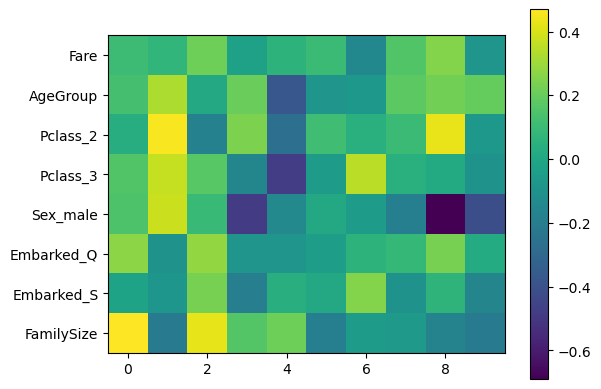

In [496]:
plt.Figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(np.arange(df_test.columns.size), df_test.columns)
plt.colorbar()

# 4. Submission

In [497]:
mlp.fit(X, y)
y_pred = mlp.predict(X_pred)
df_sub['Survived'] = y_pred
df_sub.to_csv(save_path, index=False)